## Principle Component Analysis
Principle Component Analysis or PCA, was introduced by Karl Pearson in 1901 as a way to transform a dataset in $m$ dimensions into a new coordinate system. This coordinate transform puts the observations (datapoints) into dimensions that are made up of linear combinations (i.e. sums) of the original dimensions, and arranged in such a way that the dimensions explain decreasing amounts of the variation present in the data. Multi-dimensional data that might be appropriate for PCA occur all over the biological world-- for instance the genotype of a individual at many loci, or the level of transcription of a large number of genes for a particular cell. 


## `Scikit-learn`
To play with PCA and other clustering algorithms we will use a [fantastic python package](https://scikit-learn.org/stable/index.html) that is aimed at machine learning (a subset of statistics). Install it on your machine using the following

`conda install scikit-learn`

we are going to start by look at a classic dataset, Edgar Anderson's botanical observations of three Iris species. 

In [1]:
!mamba install scitkit-learn --yes


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (0.27.0) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['scitkit-learn']

[+] 0.0s
[+] 0.1s
bioconda/osx-64    ━━━━━━━━╸━━━━━━━━━━━━━━━━   0.0 B /  ??.?MB

In [2]:
import sklearn
from sklearn import datasets
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

iris = datasets.load_iris()
df_iris = pd.DataFrame(iris.data,columns=iris.feature_names)
df_iris['species'] = iris.target_names[iris.target]

# Take a look at df_iris
df_iris

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


We can plot pairwise comparisons using Seaborn's `pairplot()` function to see if there are striking correlations between any two features of the iris data set. If any two features are highly correlated, we may assume we can summarize those two features with a single axis (i.e. "new" feature) that includes both.

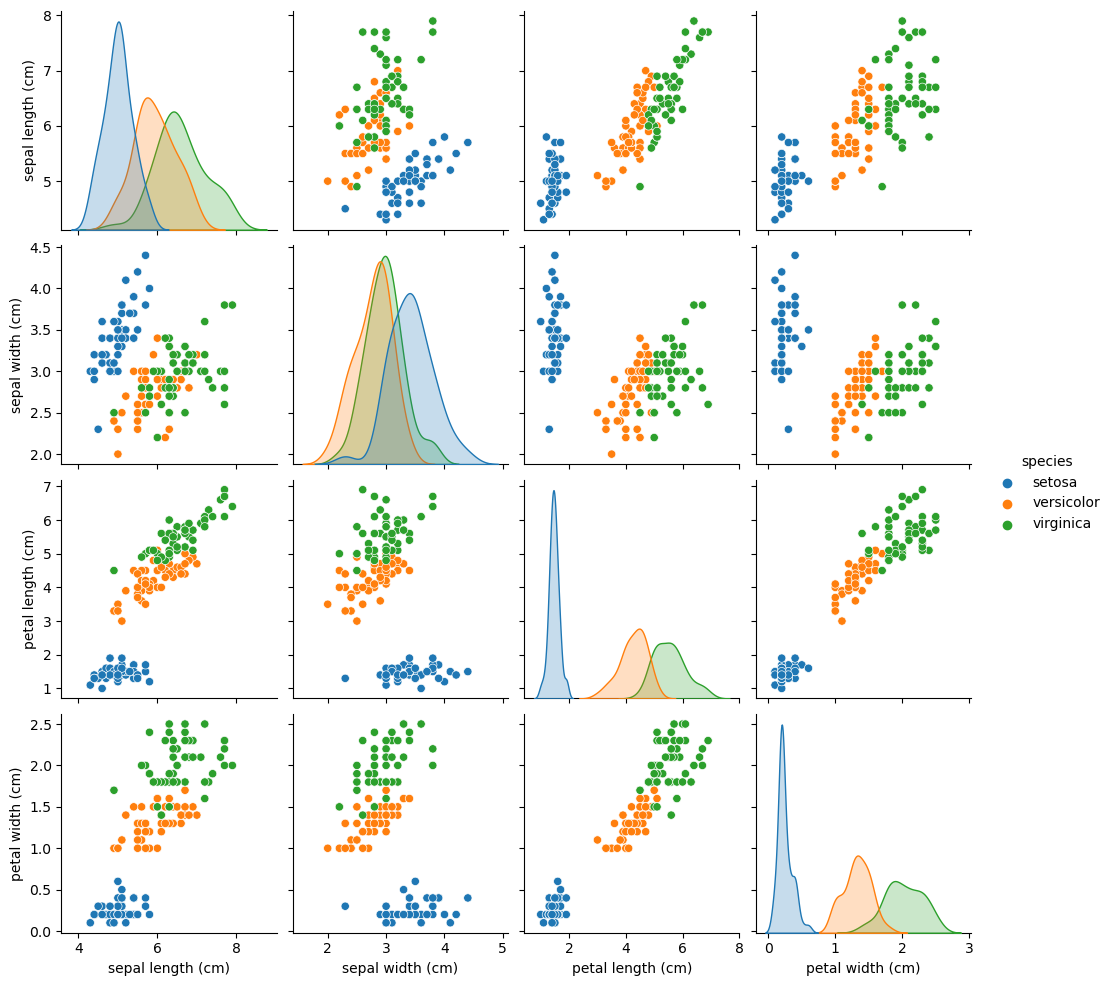

In [3]:
sns.pairplot(df_iris, hue='species')

Right away from this plot we can notice that *versicolor* and *virginica* are more similar to each other than to *setosa*.  There is also a strong correlation between *petal length* and *petal width*. Let's focus on these two parameters to explain how we do PCA.

Let's start by plotting petal length against width. We will add a "marker" for where the means of the two traits are.

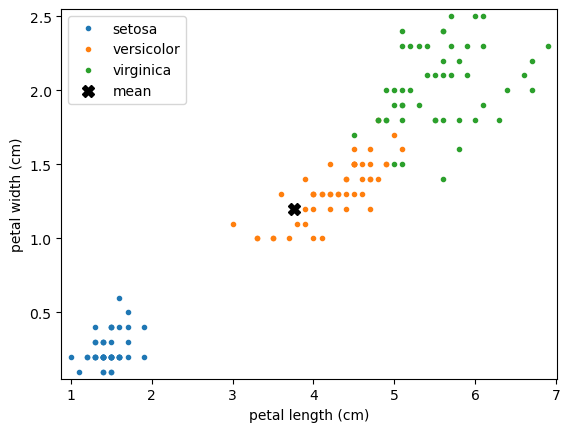

In [4]:
# Compute the mean
m = np.array([df_iris['petal length (cm)'].mean(), 
              df_iris['petal width (cm)'].mean()])

# Plot petal length vs petal width only
for key, group in df_iris.groupby(['species']):
    plt.plot(group['petal length (cm)'], group['petal width (cm)'],
               label=key, marker='.', linestyle='none')

# Add the mean value to the plot
plt.plot(m[0], m[1], marker='X', color='black', markersize=8,
         linestyle='none', label='mean')

plt.legend(loc=0)
plt.margins(0.02)
plt.xlabel('petal length (cm)')
plt.ylabel('petal width (cm)');

# A quick look at the axes of variation
PCA summarizes a dataset by the amount of variation that occurs along each axis, and uses that summary to transform the data into a new coordinate axis. To give you a sense of how this summary works, we will walk through the first steps in class.

We will take the iris data, center it (i.e. make each column mean zero), compute the [covariance matrix](https://en.wikipedia.org/wiki/Covariance_matrix) of the data, and then compute the [eigenvectors and eigenvalues](https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors) of that covariance matrix. This procedure amounts to fitting best fit lines along the orthogonal axes that best describe a dataset. 

Okay so let's go through this first bit here. You will do the whole manual proceedure in discussion as well.

1. Center our dataset

In [5]:
# Substract the mean from the measurements.
df_centered = df_iris.loc[:, ['petal length (cm)', 'petal width (cm)']]
for col in df_centered.columns:
    df_centered[col] -= df_centered[col].mean()
df_centered.head()

,petal length (cm),petal width (cm)
0,-2.358,-0.999333
1,-2.358,-0.999333
2,-2.458,-0.999333
3,-2.258,-0.999333
4,-2.358,-0.999333


2. Compute the covariance matrix of the data, and then get the eigen decomposition of that matrix to get eigenvectors and eigenvalues. 

In [6]:
cov_mat = np.cov(df_centered.transpose())
print('Covariance matrix \n', cov_mat)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors\n', eig_vecs)
print('\nEigenvalues\n', eig_vals)

Covariance matrix 
 [[3.11627785 1.2956094 ]
 [1.2956094  0.58100626]]
Eigenvectors
 [[ 0.92177769 -0.38771882]
 [ 0.38771882  0.92177769]]

Eigenvalues
 [3.66123805 0.03604607]


these eigenvectors tell us the directions of maximal variation within our data and the eigenvalues tell us the magnitudes of those vectors. having computed those we will plot them on to our original plot of petal length vs petal width 

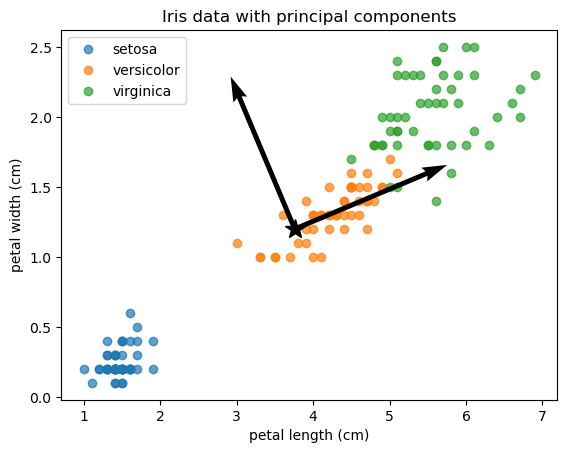

In [7]:
# Plot Petal length vs petal width only
for key, group in df_iris.groupby(['species']):
    plt.plot(group['petal length (cm)'], group['petal width (cm)'],
               label=key, marker='o', linestyle='none', alpha=0.7)

# Add the mean value to the plot
plt.plot(m[0], m[1], marker='*', color='black', markersize=15)

# Add arrows showing the eigenvectors
plt.quiver([m[0]]*2, [m[1]]*2, eig_vecs[:,1], eig_vecs[:,0], zorder=11, 
           width=0.01, scale=3)
    
# Tidy up plot
plt.legend()
#plt.margins(0.02)
plt.xlabel('petal length (cm)')
plt.ylabel('petal width (cm)')
plt.title('Iris data with principal components');

make sense? see the planes in which those arrows lie? They are describing variation in our 2D data! 

Now there are a bunch of other steps to complete the PCA that we won't cover here but that you will do in discussion section

# Doing PCA the easy way
`scikit-learn` makes doing all this PCA business a snap. Let's go through the very simples steps you would take to do a _full_ PCA analysis on the Iris dataset. We start by looking at how much of the variation is explained by principal components.

In [8]:
from sklearn import decomposition
# Instantiate the PCA object
sklearn_pca = sklearn.decomposition.PCA()

# Pass the data to the fit method
sklearn_pca.fit(df_iris[iris.feature_names])

# Print the variance explained
print('Variance percent explained\n', sklearn_pca.explained_variance_ratio_)

Variance percent explained
 [0.92461872 0.05306648 0.01710261 0.00521218]


We can see that the first component captures 92% of the variability in the data! We can now easily project our 4-D dataset into any $k$ dimensional space we would like. Since we've already seen a 0-D and 1-D reduction, let's look at the data in 2-D space.

In [9]:
# Perform the PCA again retaining only the top 2 components
sklearn_pca = sklearn.decomposition.PCA(n_components=2)
sklearn_pca.fit(df_iris[iris.feature_names])

# Project the data into this 2D space and convert it back to a tidy dataframe
df_2D = pd.DataFrame(sklearn_pca.transform(df_iris[iris.feature_names]),
                     columns=['PCA1', 'PCA2'])

# Create a column for species name
df_2D['species'] = df_iris['species']

# Look at the result
df_2D.head()

,PCA1,PCA2,species
0,-2.684126,0.319397,setosa
1,-2.714142,-0.177001,setosa
2,-2.888991,-0.144949,setosa
3,-2.745343,-0.318299,setosa
4,-2.728717,0.326755,setosa


Now we can plot our original 4-D data onto a 2-D space that retains nearly 93% of the variability.

<AxesSubplot:xlabel='PCA1', ylabel='PCA2'>

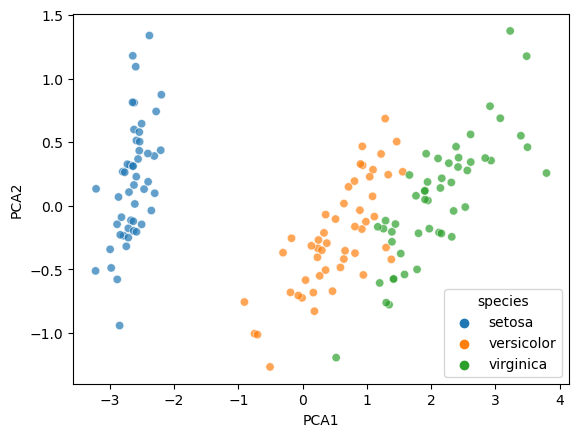

In [10]:
# plot using seaborn again

sns.scatterplot(df_2D,x=df_2D.PCA1,y=df_2D.PCA2,hue=df_2D.species,alpha=0.7)


# Supervised Machine Learning for classification
Looking at the PCA plot above, it appears that we might be able to train an algorithm to classify individual observations into species. Indeed this sort of *classification* task has become increasingly popular as powerful
algorithms and computer hardware become increasingly available. The basic idea behind supervised machine learning is to use known, labeled examples to train an oracle such that it can make predictions (i.e. classifications) for new, unlabelled data points.

`scikit-learn` has a ton of this implemented for us already. We will use a Support Vector Machine (SVM) to perform classification of the iris dataset and we will then take a look at how good our predictions are using a so-called "confusion matrix"

Confusion matrix, without normalization
[[13  0  0]
 [ 0 10  6]
 [ 0  0  9]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.   0.62 0.38]
 [0.   0.   1.  ]]


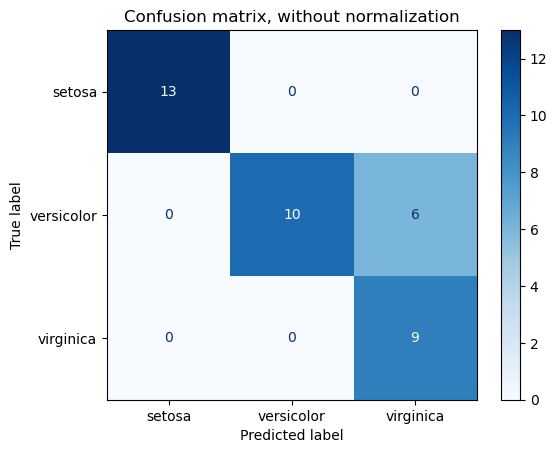

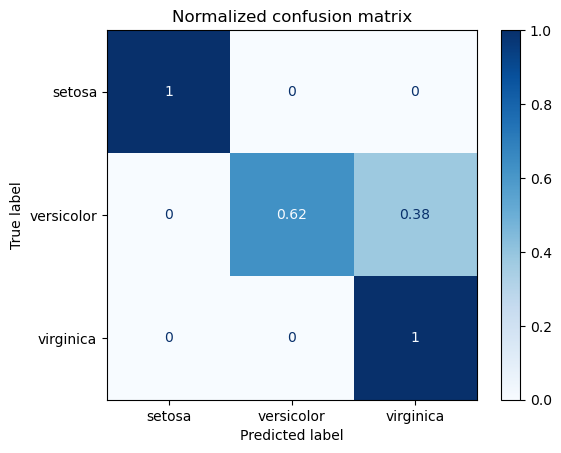

In [11]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(kernel='linear', C=0.01).fit(X_train, y_train)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

# Decision surface
let's plot the decisions surface along which our SVM is deciding which species it's looking at. to visualize this we will reduce the problem to two dimensional data, just to make it easy to look at, and we will plot what the SVMs are actually examining

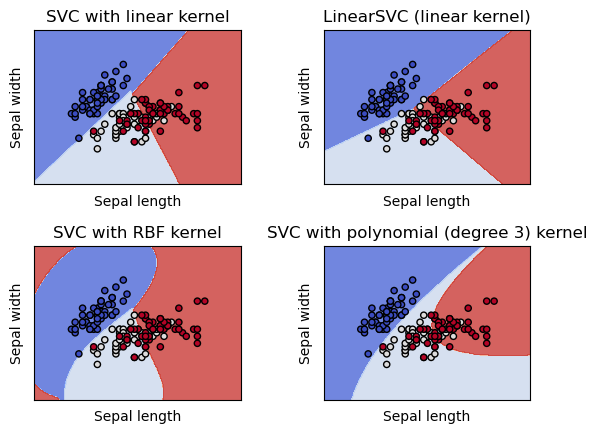

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets


def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


# Take the first two features. We could avoid this by using a two-dim dataset
X = iris.data[:, :2]
#y = iris.target

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
models = (svm.SVC(kernel='linear', C=C),
          svm.LinearSVC(C=C, max_iter=10000),
          svm.SVC(kernel='rbf', gamma=0.7, C=C),
          svm.SVC(kernel='poly', degree=3, gamma='auto', C=C))
models = (clf.fit(X, y) for clf in models)

# title for the plots
titles = ('SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel')

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()